In [5]:
import os
import tensorflow as tf
from transformers import *

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm
import numpy as np
import re

# import setGPU

In [2]:
# 시각화

def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string], '')
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

In [3]:
SEED_NUM = 1234
tf.random.set_seed(SEED_NUM)

In [11]:
def get_initializer(initializer_range=0.02):
    """Creates a `tf.initializers.truncated_normal` with the given range.
    Args:
        initializer_range: float, initializer range for stddev.
    Returns:
        TruncatedNormal initializer with stddev = `initializer_range`.
    """
    return tf.keras.initializers.TruncatedNormal(stddev=initializer_range)

class TFGPT2Classifier(tf.keras.Model):
    def __init__(self, dir_path=None):
        super(TFGPT2Classifier, self).__init__()
        
        if dir_path is None:
            dir_path = 'gpt2'
        self.gpt2 = TFGPT2Model.from_pretrained(dir_path)
        self.dropout = tf.keras.layers.Dropout(self.gpt2.config.summary_first_dropout)
        self.classifier = tf.keras.layers.Dense(
            self.gpt2.config._num_labels, kernel_initializer=get_initializer(self.gpt2.config.initializer_range), name="classifier"
        )
        
    def call(self, inputs):
#         if len(inputs) == 1:
#             gpt_inputs = inputs
#             attention_mask = None
#         else:
#             gpt_inputs = inputs[0]
#             attention_mask = inputs[1]
        
        outputs = self.gpt2(inputs)#, attention_mask=attention_mask)
        pooled_output = outputs[0][:, -1]

        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)

        outputs = (logits,) + outputs[2:] 

        return outputs

In [12]:
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
model = TFGPT2Classifier("gpt2")

In [8]:
#random seed 고정

tf.random.set_seed(0)
np.random.seed(0)

BATCH_SIZE = 8
NUM_EPOCHS = 20
VALID_SPLIT = 0.2
MAX_LEN = 128
DATA_IN_PATH = 'data_in/ENG'
DATA_OUT_PATH = "data_out/ENG"

In [13]:
vocab = tokenizer.get_vocab()

tokenizer.pad_token = '#'
tokenizer.cls_token = '@'
tokenizer.sep_token = '$'

# Special Tokens
print(tokenizer.all_special_tokens, "\n", tokenizer.all_special_ids)

# Test Tokenizers
kor_encode = tokenizer.encode("안녕하세요, 반갑습니다")
eng_encode = tokenizer.encode("Hello world")

kor_decode = tokenizer.decode(kor_encode)
eng_decode = tokenizer.decode(eng_encode)

print(kor_encode)
print(eng_encode)
print(kor_decode)
print(eng_decode)

['<|endoftext|>', '$', '#', '@'] 
 [50256, 3, 2, 31]
[168, 243, 230, 167, 227, 243, 47991, 246, 168, 226, 116, 168, 248, 242, 11, 31619, 108, 246, 166, 108, 239, 168, 232, 113, 46695, 230, 46695, 97]
[15496, 995]
안녕하세요, 반갑습니다
Hello world


# Bag of Words Meets Bags of Popcorn (Eng)

In [104]:
import re
import json
import numpy as np
from bs4 import BeautifulSoup
import html5lib
from nltk.corpus import stopwords

In [105]:
# Load Train dataset
TRAIN_BOW_DF = os.path.join(DATA_IN_PATH, 'popcorn', 'labeledTrainData.tsv')

train_data_bow = pd.read_csv(TRAIN_BOW_DF, header = 0, delimiter = '\t', quoting = 3)
train_data_bow.head()

,id,sentiment,review
0,"""5814_8""",1,"""With all this stuff going down at the moment ..."
1,"""2381_9""",1,"""\""The Classic War of the Worlds\"" by Timothy ..."
2,"""7759_3""",0,"""The film starts with a manager (Nicholas Bell..."
3,"""3630_4""",0,"""It must be assumed that those who praised thi..."
4,"""9495_8""",1,"""Superbly trashy and wondrously unpretentious ..."


In [155]:
# 4장의 기존 전처리를 follow up한다. 다만, Bert가 사전학습을 할 때 일반적으로 특수문자나 불용어를 제거하지 않기 때문에 제외한다.

stop_words = set(stopwords.words('english')) # 영어 불용어들의 set을 만든다.

def preprocessing( review, remove_stopwords = False ): 
    # 불용어 제거는 옵션으로 선택 가능하다.
    
    # 1. HTML 태그 제거
    review_text = BeautifulSoup(review, "html5lib").get_text()	

#     # 2. 영어가 아닌 특수문자들을 공백(" ")으로 바꾸기
#     review_text = re.sub("[^a-zA-Z]", " ", review_text)

    # 3. 대문자들을 소문자로 바꾸고 공백단위로 텍스트들 나눠서 리스트로 만든다.
    words = review_text.lower().split()

    if remove_stopwords: 
        # 4. 불용어들을 제거
    
        #영어에 관련된 불용어 불러오기
        stops = set(stopwords.words("english"))
        # 불용어가 아닌 단어들로 이루어진 새로운 리스트 생성
        words = [w for w in words if not w in stops]
        # 5. 단어 리스트를 공백을 넣어서 하나의 글로 합친다.	
        clean_review = ' '.join(words)

    else: # 불용어 제거하지 않을 때
        clean_review = ' '.join(words)

    return clean_review

# preprocessing(train_sent, remove_stopwords = False)

In [156]:
# Simliarty tokenizer

# 참조: https://huggingface.co/transformers/main_classes/tokenizer.html?highlight=encode_plus#transformers.PreTrainedTokenizer.encode_plus

def class_tokenizer(sent1, MAX_LEN):
    
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.

    encoded_dict = tokenizer.encode_plus(
        text = sent1,     
        add_special_tokens = False, # Add '[CLS]' and '[SEP]'
        max_length = MAX_LEN,           # Pad & truncate all sentences.
        pad_to_max_length = True,
        return_attention_mask = True   # Construct attn. masks.
        
    )
    
    input_id = encoded_dict['input_ids'] + [tokenizer.cls_token_id] # Add the encoded sentence to the list.
    
    return input_id

In [157]:
train_data_bow_sents = []
train_data_bow_labels = []

for train_sent, train_label in zip(train_data_bow["review"], train_data_bow["sentiment"]):
    try:
        # Max Len의 경우 4장에 EDA값을 추출하였던 길이 174를 사용한다.
#         token_sent = tokenizer.encode(preprocessing(train_sent[:174], remove_stopwords = False))
        token_sent = class_tokenizer(preprocessing(train_sent, remove_stopwords = False), 174)
        
    except Exception as e:
        print("Error message: {}".format(e))
        print("sentence: {}".format(train_sent))
        continue
        
    train_data_bow_sents.append(token_sent) #append는 빼 놓고 한다.
    train_data_bow_labels.append(train_label)

# train_data_bow_sent_pads = pad_sequences(train_data_bow_sents, maxlen=MAX_LEN, padding='post', value=2)
train_data_bow_sents = np.asarray(train_data_bow_sents, dtype=np.int32)
train_data_bow_labels = np.asarray(train_data_bow_labels, dtype=np.int32) #레이블 토크나이징 리스트

print("num sents, attention_masks, labels {}, {}".format(len(train_data_bow_sents), len(train_data_bow_labels)))

num sents, attention_masks, labels 50, 50


In [159]:
# 학습 준비하기
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5, epsilon=1e-08, clipnorm=1.0)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

In [160]:
model_name = "tf2_gpt2_bag_of_words"

# overfitting을 막기 위한 ealrystop 추가
earlystop_callback = EarlyStopping(monitor='val_accuracy', min_delta=0.0001,patience=999)
# min_delta: the threshold that triggers the termination (acc should at least improve 0.0001)
# patience: no improvment epochs (patience = 1, 1번 이상 상승이 없으면 종료)\

checkpoint_path = DATA_OUT_PATH + model_name + '/weights.h5'
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create path if exists
if os.path.exists(checkpoint_dir):
    print("{} -- Folder already exists \n".format(checkpoint_dir))
else:
    os.makedirs(checkpoint_dir, exist_ok=True)
    print("{} -- Folder create complete \n".format(checkpoint_dir))
    
cp_callback = ModelCheckpoint(
    checkpoint_path, monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=True)

# 학습과 eval 시작
history = model.fit(train_data_bow_sents, train_data_bow_labels, epochs=NUM_EPOCHS, batch_size=BATCH_SIZE,
                    validation_split = VALID_SPLIT, callbacks=[earlystop_callback, cp_callback], validation_steps=2)

#steps_for_epoch

print(history.history)

data_out/ENGtf2_gpt2_bag_of_words -- Folder already exists 

Train on 40 samples, validate on 10 samples
Epoch 1/20
32/40 [=======================>......] - ETA: 6s - loss: 1.2745 - accuracy: 0.5625 
Epoch 00001: val_accuracy improved from -inf to 0.50000, saving model to data_out/ENGtf2_gpt2_bag_of_words/weights.h5
40/40 [==============================] - 33s 821ms/sample - loss: 1.1659 - accuracy: 0.6000 - val_loss: 1.0520 - val_accuracy: 0.5000
Epoch 2/20
32/40 [=======================>......] - ETA: 4s - loss: 0.4052 - accuracy: 0.8125
Epoch 00002: val_accuracy did not improve from 0.50000
40/40 [==============================] - 21s 536ms/sample - loss: 0.3687 - accuracy: 0.8250 - val_loss: 0.8677 - val_accuracy: 0.5000
Epoch 3/20
32/40 [=======================>......] - ETA: 4s - loss: 0.1271 - accuracy: 0.9688
Epoch 00003: val_accuracy improved from 0.50000 to 0.60000, saving model to data_out/ENGtf2_gpt2_bag_of_words/weights.h5
40/40 [==============================] - 22s 551ms

KeyboardInterrupt: 

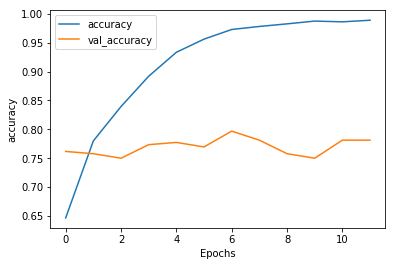

In [16]:
plot_graphs(history, 'accuracy')

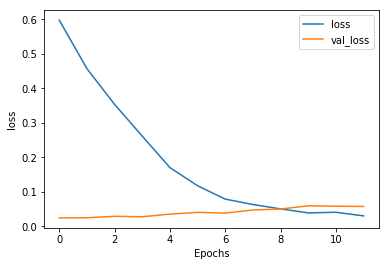

In [17]:
plot_graphs(history, 'loss')

# Bag of Words Test Dataset (제출 확인 필요)

In [17]:
TEST_BOW_DF = os.path.join(DATA_IN_PATH, 'popcorn', 'testData.tsv')

test_data_bow = pd.read_csv(TEST_BOW_DF, header=0, delimiter="\t", quoting=3)
test_data_bow.head()

,id,review
0,"""12311_10""","""Naturally in a film who's main themes are of ..."
1,"""8348_2""","""This movie is a disaster within a disaster fi..."
2,"""5828_4""","""All in all, this is a movie for kids. We saw ..."
3,"""7186_2""","""Afraid of the Dark left me with the impressio..."
4,"""12128_7""","""A very accurate depiction of small time mob l..."


In [19]:
test_data_bow_sents = []
test_data_bow_idx = []

for test_sent, test_idx in zip(test_data_bow["review"], test_data_bow["id"]):
    try:
        # Max Len의 경우 4장에 EDA값을 추출하였던 길이 174를 사용한다.
        token_sent = class_tokenizer(preprocessing(train_sent, remove_stopwords = False), 174)
        
    except Exception as e:
        print("Error message: {}".format(e))
        print("sentence: {}".format(test_sent))
        continue
        
    test_data_bow_sents.append(token_sent) #append는 빼 놓고 한다.
    test_data_bow_idx.append(test_idx)

train_data_bow_sents = np.asarray(train_data_bow_sents, dtype=np.int32)

In [22]:
print("num sents, labels {}, {}".format(len(test_data_bow_sents), len(test_data_bow_idx)))

num sents, labels 25000, 25000


In [ ]:
predictions = model.predict(test_input, batch_size=BATCH_SIZE)
predictions = np.argmax(predictions, axis=1)

In [ ]:
output = pd.DataFrame(data={"id": list(test_data_bow_idx), "sentiment":list(predictions)})
output.to_csv(DATA_OUT_PATH + 'movie_review_result_gpt2.csv', index=False, quoting=3)

# Quora Simliarity (ENG)

In [6]:
# BASE PARAM

BATCH_SIZE = 8
NUM_EPOCHS = 20
VALID_SPLIT = 0.1
MAX_LEN = 31 * 2

In [9]:
# Load Train dataset
TRAIN_QUORA_DF = os.path.join(DATA_IN_PATH, 'quora', 'train.csv')

train_data_quora = pd.read_csv(TRAIN_QUORA_DF, header = 0)
train_data_quora.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [14]:
# Simliarty tokenizer

# 참조: https://huggingface.co/transformers/main_classes/tokenizer.html?highlight=encode_plus#transformers.PreTrainedTokenizer.encode_plus

def sim_tokenizer(sent1, sent2, MAX_LEN):
    
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.

    encoded_dict = tokenizer.encode_plus(
        text = sent1,                      # Sentence to encode.
        text_pair = sent2,
        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
        max_length = MAX_LEN,           # Pad & truncate all sentences.
        pad_to_max_length = True,
        return_attention_mask = True   # Construct attn. masks.
        
    )
    
    input_id = encoded_dict['input_ids'][1:] + [tokenizer.cls_token_id]# Add the encoded sentence to the list.
#     attention_mask = encoded_dict['attention_mask'] # And its attention mask (simply differentiates padding from non-padding).
#     token_type_id = encoded_dict['token_type_ids'] # diffenciate two sentences
    
    return input_id

In [17]:
# 토크나이저를 제외하고는 5장에서 처리한 방식과 유사하게 접근
FILTERS = "([~.,!?\"':;)(])"

change_filter = re.compile(FILTERS)

input_ids = []
# attention_masks = []
# token_type_ids = []

for sent1, sent2 in zip(train_data_quora['question1'], train_data_quora['question2']):
    
    sent1 = re.sub(change_filter, "", str(sent1))
    sent2 = re.sub(change_filter, "", str(sent2))
    
    input_id = sim_tokenizer(sent1, sent2, MAX_LEN)
    
    input_ids.append(input_id)
#     attention_masks.append(attention_mask)
#     token_type_ids.append(token_type_id)
    
train_quora_input_ids = np.array(input_ids, dtype=int)
# train_quora_attention_masks = np.array(attention_masks, dtype=int)
# train_quora_type_ids = np.array(token_type_ids, dtype=int)
# train_quora_inputs = (train_quora_input_ids, train_quora_attention_masks, train_quora_type_ids)

train_quora_labels = np.array(train_data_quora['is_duplicate'], dtype=int)

print("# sents: {}, # labels: {}".format(len(train_quora_input_ids), len(train_quora_labels)))

# sents: 50, # labels: 50


In [18]:
# 학습 준비하기
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4, epsilon=1e-08, clipnorm=1.0)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

In [22]:
model_name = "tf2_gpt_quora"

# overfitting을 막기 위한 ealrystop 추가
earlystop_callback = EarlyStopping(monitor='val_accuracy', min_delta=0.0001,patience=3)
# min_delta: the threshold that triggers the termination (acc should at least improve 0.0001)
# patience: no improvment epochs (patience = 1, 1번 이상 상승이 없으면 종료)\

checkpoint_path = DATA_OUT_PATH + model_name + '/weights.h5'
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create path if exists
if os.path.exists(checkpoint_dir):
    print("{} -- Folder already exists \n".format(checkpoint_dir))
else:
    os.makedirs(checkpoint_dir, exist_ok=True)
    print("{} -- Folder create complete \n".format(checkpoint_dir))
    
cp_callback = ModelCheckpoint(
    checkpoint_path, monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=True)

# 학습과 eval 시작
history = model.fit(train_quora_input_ids, train_quora_labels, epochs=NUM_EPOCHS,
            batch_size=BATCH_SIZE, validation_split = VALID_SPLIT, callbacks=[earlystop_callback, cp_callback], validation_steps=2)

#steps_for_epoch

print(history.history)

data_out/ENGtf2_bert_quora -- Folder already exists 

Train on 40 samples, validate on 10 samples
Epoch 1/20
32/40 [=======================>......] - ETA: 4s - loss: 2.5190 - accuracy: 0.5000
Epoch 00001: val_accuracy improved from -inf to 0.80000, saving model to data_out/ENGtf2_bert_quora/weights.h5
40/40 [==============================] - 23s 569ms/sample - loss: 2.1371 - accuracy: 0.5500 - val_loss: 0.5570 - val_accuracy: 0.8000
Epoch 2/20
32/40 [=======================>......] - ETA: 2s - loss: 0.7543 - accuracy: 0.5938
Epoch 00002: val_accuracy did not improve from 0.80000
40/40 [==============================] - 15s 379ms/sample - loss: 0.7950 - accuracy: 0.5500 - val_loss: 0.6199 - val_accuracy: 0.7000
Epoch 3/20
32/40 [=======================>......] - ETA: 2s - loss: 0.6584 - accuracy: 0.6875
Epoch 00003: val_accuracy did not improve from 0.80000
40/40 [==============================] - 16s 390ms/sample - loss: 0.6340 - accuracy: 0.7250 - val_loss: 0.4783 - val_accuracy: 0.80

In [23]:
plot_graphs(history, 'accuracy')

NameError: name 'plot_graphs' is not defined

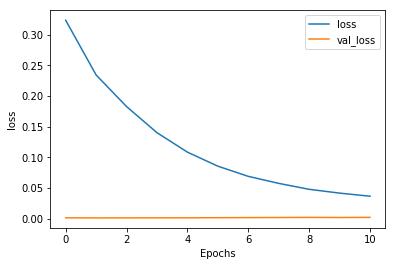

In [68]:
plot_graphs(history, 'loss')

# Quora Simliarity TEST

In [75]:
# 테스트 데이터셋 로드

TEST_QUORA_DF = os.path.join(DATA_IN_PATH, 'quora', 'test.csv')

test_data_quora = pd.read_csv(TEST_QUORA_DF, encoding="utf-8")
valid_ids = [type(x) ==int for x in test_data_quora.test_id]
test_data = test_data_quora[valid_ids].drop_duplicates()

test_data_quora.head()

,test_id,question1,question2
0,0,How does the Surface Pro himself 4 compare wit...,Why did Microsoft choose core m3 and not core ...
1,1,Should I have a hair transplant at age 24? How...,How much cost does hair transplant require?
2,2,What but is the best way to send money from Ch...,What you send money to China?
3,3,Which food not emulsifiers?,What foods fibre?
4,4,"How ""aberystwyth"" start reading?",How their can I start reading?


In [105]:
test_data_quora = test_data_quora

In [108]:
# Test dataset 전처리

input_ids = []
# attention_masks = []
# token_type_ids = []

for sent1, sent2 in zip(test_data_quora['question1'], test_data_quora['question2']):
    
    sent1 = re.sub(change_filter, "", str(sent1))
    sent2 = re.sub(change_filter, "", str(sent2))
    
    input_id = quora_tokenizer(sent1, sent2, MAX_LEN)
    
    input_ids.append(input_id)
#     attention_masks.append(attention_mask)
#     token_type_ids.append(token_type_id)
    
test_quora_input_ids = np.array(input_ids, dtype=int)
# test_quora_attention_masks = np.array(attention_masks, dtype=int)
# test_quora_type_ids = np.array(token_type_ids, dtype=int)
# test_quora_inputs = (train_quora_input_ids, train_quora_attention_masks, train_quora_type_ids)

print("# sents: {}".format(len(test_quora_input_ids)))

# sents: 1000


In [117]:
# 테스트 값 예측하기

predictions = model.predict(test_quora_input_ids, batch_size=512)
# predictions = model.predict(test_quora_inputs)

In [100]:
predictions = np.argmax(predictions, axis=1)

output = pd.DataFrame( data={"test_id":test_data_quora['test_id'], "is_duplicate": list(predictions)} )
output.to_csv("bert_predict.csv", index=False, quoting=3)

ValueError: array length 404290 does not match index length 2345796